In [ ]:
! pip install qiskit
!pip install qiskit_machine_learning
!pip install pylatexenc

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output
from qiskit import QuantumCircuit
from qiskit.algorithms.optimizers import COBYLA, L_BFGS_B
from qiskit.circuit import Parameter
from qiskit.circuit.library import RealAmplitudes, ZZFeatureMap
from qiskit.utils import algorithm_globals

from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier, VQC
from qiskit_machine_learning.algorithms.regressors import NeuralNetworkRegressor, VQR
from qiskit_machine_learning.neural_networks import SamplerQNN, EstimatorQNN

algorithm_globals.random_seed = 42

In [ ]:
dataset = pd.read_csv('/content/supermarket_sales - Sheet1.csv')

dataset = dataset.dropna()
dataset

,Invoice ID,Branch,City,Customer type,Gender,Product line,Unit price,Quantity,Tax 5%,Total,Date,Time,Payment,cogs,gross margin percentage,gross income,Rating
0,750-67-8428,A,Yangon,Member,Female,Health and beauty,74.69,7,26.1415,548.9715,1/5/2019,13:08,Ewallet,522.83,4.761905,26.1415,9.1
1,226-31-3081,C,Naypyitaw,Normal,Female,Electronic accessories,15.28,5,3.8200,80.2200,3/8/2019,10:29,Cash,76.40,4.761905,3.8200,9.6
2,631-41-3108,A,Yangon,Normal,Male,Home and lifestyle,46.33,7,16.2155,340.5255,3/3/2019,13:23,Credit card,324.31,4.761905,16.2155,7.4
3,123-19-1176,A,Yangon,Member,Male,Health and beauty,58.22,8,23.2880,489.0480,1/27/2019,20:33,Ewallet,465.76,4.761905,23.2880,8.4
4,373-73-7910,A,Yangon,Normal,Male,Sports and travel,86.31,7,30.2085,634.3785,2/8/2019,10:37,Ewallet,604.17,4.761905,30.2085,5.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,233-67-5758,C,Naypyitaw,Normal,Male,Health and beauty,40.35,1,2.0175,42.3675,1/29/2019,13:46,Ewallet,40.35,4.761905,2.0175,6.2
996,303-96-2227,B,Mandalay,Normal,Female,Home and lifestyle,97.38,10,48.6900,1022.4900,3/2/2019,17:16,Ewallet,973.80,4.761905,48.6900,4.4
997,727-02-1313,A,Yangon,Member,Male,Food and beverages,31.84,1,1.5920,33.4320,2/9/2019,13:22,Cash,31.84,4.761905,1.5920,7.7
998,347-56-2442,A,Yangon,Normal,Male,Home and lifestyle,65.82,1,3.2910,69.1110,2/22/2019,15:33,Cash,65.82,4.761905,3.2910,4.1


In [ ]:
# Scale the data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
dataset[["Unit price","Quantity","Total","cogs","gross margin percentage","gross income","Rating"]] = scaler.fit_transform(dataset[["Unit price","Quantity","Total","cogs","gross margin percentage","gross income","Rating"]])

# Split the data into training and testing sets
from sklearn.model_selection import train_test_split
X = dataset[["Unit price","Quantity","Total","cogs","gross margin percentage","gross income","Rating"]].values
y = dataset["Gender"].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

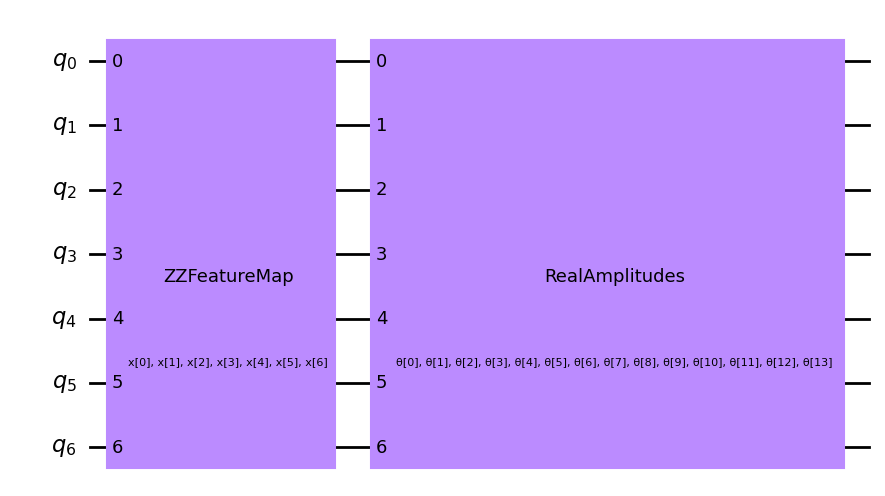

In [ ]:
from pylatexenc import *
num_inputs=7
# construct feature map
feature_map = ZZFeatureMap(num_inputs)

# construct ansatz
ansatz = RealAmplitudes(num_inputs, reps=1)

# construct quantum circuit
qc = QuantumCircuit(num_inputs)
qc.append(feature_map, range(num_inputs))
qc.append(ansatz, range(num_inputs))
#qc.decompose().draw(output='mpl')
#qc.draw()
qc.draw(output="mpl")

In [ ]:
# parity maps bitstrings to 0 or 1
def parity(x):
    return "{:b}".format(x).count("1") % 2


output_shape = 2  # corresponds to the number of classes, possible outcomes of the (parity) mapping.

In [ ]:
# construct QNN
sampler_qnn = SamplerQNN(
    circuit=qc,
    input_params=feature_map.parameters,
    weight_params=ansatz.parameters,
    interpret=parity,
    output_shape=output_shape,
)

In [ ]:
# callback function that draws a live plot when the .fit() method is called
def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

In [ ]:
# construct classifier
sampler_classifier = NeuralNetworkClassifier(
    neural_network=sampler_qnn, optimizer=COBYLA(maxiter=100), callback=callback_graph
)

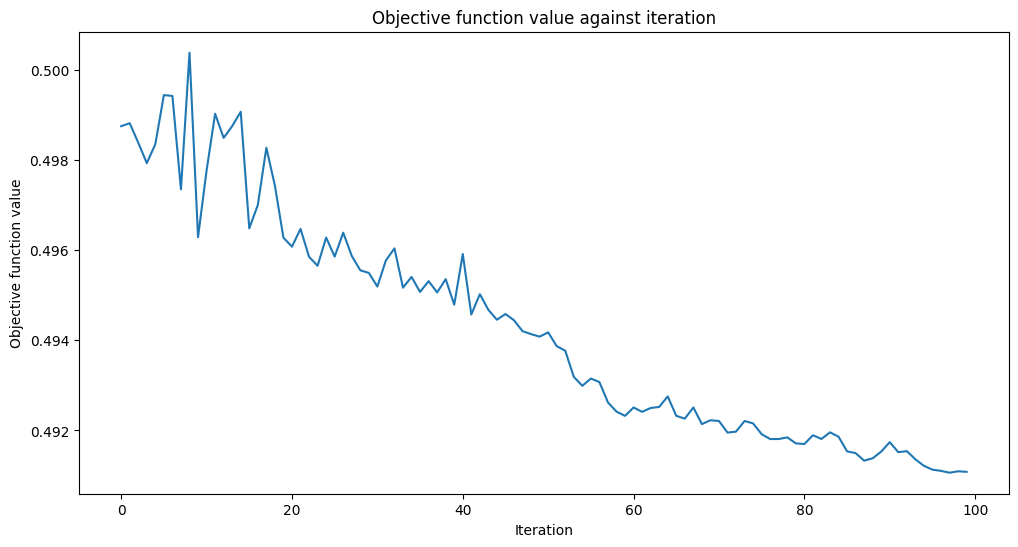

0.59625

In [ ]:
# create empty array for callback to store evaluations of the objective function
objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)

# fit classifier to data
sampler_classifier.fit(X_train, y_train)

# return to default figsize
plt.rcParams["figure.figsize"] = (6, 4)

# score classifier
sampler_classifier.score(X_train, y_train)

In [ ]:
score=sampler_classifier.score(X_train, y_train)
print(f"accuracy score: ",score)
# score classifier
print(f"Accuracy from the train data : {np.round(100 * sampler_classifier.score(X_train, y_train), 2)}%")

accuracy score:  0.59625
Accuracy from the train data : 59.62%


In [ ]:
# Generate predictions on the test dataset
test_predictions = sampler_classifier.predict(X_train)

from sklearn.metrics import precision_score, recall_score, f1_score

precision = precision_score(y_train, test_predictions, average='weighted')
recall = recall_score(y_train, test_predictions, average='weighted')
f1 = f1_score(y_train, test_predictions, average='weighted')

print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

Precision: 0.5575921474358975
Recall: 0.5575
F1-score: 0.5573229291716687


#end of supermarket

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output
from qiskit import QuantumCircuit
from qiskit.algorithms.optimizers import COBYLA, L_BFGS_B
from qiskit.circuit import Parameter
from qiskit.circuit.library import RealAmplitudes, ZZFeatureMap
from qiskit.utils import algorithm_globals

from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier, VQC
from qiskit_machine_learning.algorithms.regressors import NeuralNetworkRegressor, VQR
from qiskit_machine_learning.neural_networks import SamplerQNN, EstimatorQNN

algorithm_globals.random_seed = 42

In [ ]:
dataset = pd.read_csv('/content/Breast_cancer_data.csv')

dataset = dataset.dropna()
dataset

,mean_radius,mean_texture,mean_perimeter,mean_area,mean_smoothness,diagnosis
0,17.99,10.38,122.80,1001.0,0.11840,0
1,20.57,17.77,132.90,1326.0,0.08474,0
2,19.69,21.25,130.00,1203.0,0.10960,0
3,11.42,20.38,77.58,386.1,0.14250,0
4,20.29,14.34,135.10,1297.0,0.10030,0
...,...,...,...,...,...,...
564,21.56,22.39,142.00,1479.0,0.11100,0
565,20.13,28.25,131.20,1261.0,0.09780,0
566,16.60,28.08,108.30,858.1,0.08455,0
567,20.60,29.33,140.10,1265.0,0.11780,0


In [ ]:
# Scale the data
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
dataset[["mean_radius","mean_texture","mean_perimeter","mean_area","mean_smoothness"]] = scaler.fit_transform(dataset[["mean_radius","mean_texture","mean_perimeter","mean_area","mean_smoothness"]])

# Split the data into training and testing sets
from sklearn.model_selection import train_test_split
X = dataset[["mean_radius","mean_texture","mean_perimeter","mean_area","mean_smoothness"]].values
y = dataset["diagnosis"].values
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

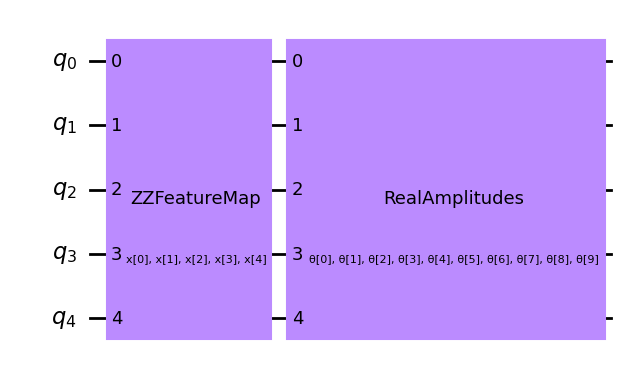

In [ ]:
from pylatexenc import *
num_inputs=5
# construct feature map
feature_map = ZZFeatureMap(num_inputs)

# construct ansatz
ansatz = RealAmplitudes(num_inputs, reps=1)

# construct quantum circuit
qc = QuantumCircuit(num_inputs)
qc.append(feature_map, range(num_inputs))
qc.append(ansatz, range(num_inputs))
#qc.decompose().draw(output='mpl')
#qc.draw()
qc.draw(output="mpl")

In [ ]:
# parity maps bitstrings to 0 or 1
def parity(x):
    return "{:b}".format(x).count("1") % 2


output_shape = 2  # corresponds to the number of classes, possible outcomes of the (parity) mapping.

In [ ]:
# construct QNN
sampler_qnn = SamplerQNN(
    circuit=qc,
    input_params=feature_map.parameters,
    weight_params=ansatz.parameters,
    interpret=parity,
    output_shape=output_shape,
)

In [ ]:
# callback function that draws a live plot when the .fit() method is called
def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

In [ ]:
# construct classifier
sampler_classifier = NeuralNetworkClassifier(
    neural_network=sampler_qnn, optimizer=COBYLA(maxiter=100), callback=callback_graph
)

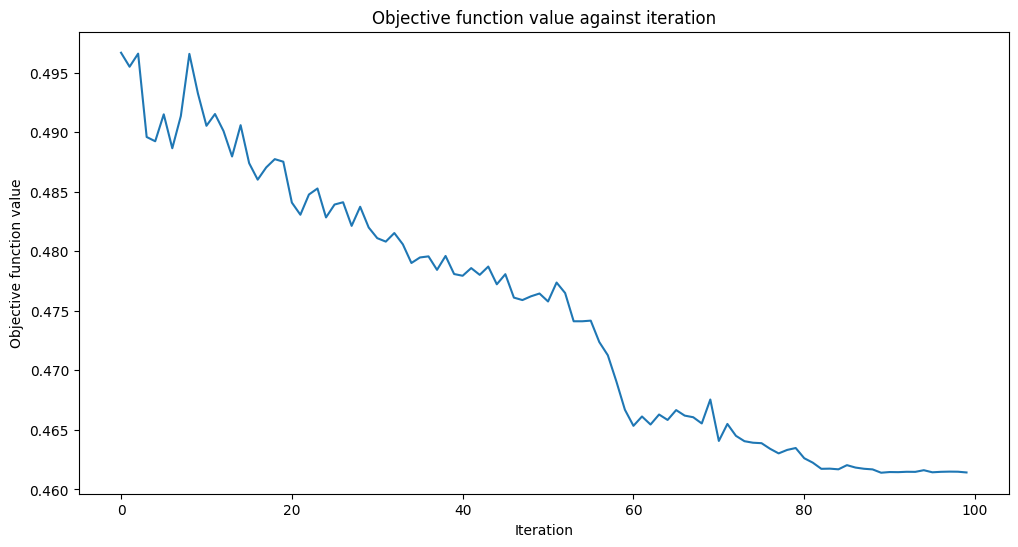

0.589010989010989

In [ ]:
# create empty array for callback to store evaluations of the objective function
objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)

# fit classifier to data
sampler_classifier.fit(X_train, y_train)

# return to default figsize
plt.rcParams["figure.figsize"] = (6, 4)

# score classifier
sampler_classifier.score(X_train, y_train)

In [ ]:
score=sampler_classifier.score(X_train, y_train)
print(f"accuracy score: ",score)
# score classifier
print(f"Accuracy from the train data : {np.round(100 * sampler_classifier.score(X_train, y_train), 2)}%")

accuracy score:  0.589010989010989
Accuracy from the train data : 58.9%


In [ ]:
# Generate predictions on the test dataset
test_predictions = sampler_classifier.predict(X_train)

from sklearn.metrics import precision_score, recall_score, f1_score

precision = precision_score(y_train, test_predictions, average='weighted')
recall = recall_score(y_train, test_predictions, average='weighted')
f1 = f1_score(y_train, test_predictions, average='weighted')

print("Precision:", precision)
print("Recall:", recall)
print("F1-score:", f1)

Precision: 0.5198149315356297
Recall: 0.589010989010989
F1-score: 0.5172529076762654


#end of cancer

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output
from qiskit import QuantumCircuit
from qiskit.algorithms.optimizers import COBYLA, L_BFGS_B
from qiskit.circuit import Parameter
from qiskit.circuit.library import RealAmplitudes, ZZFeatureMap
from qiskit.utils import algorithm_globals

from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier, VQC
from qiskit_machine_learning.algorithms.regressors import NeuralNetworkRegressor, VQR
from qiskit_machine_learning.neural_networks import SamplerQNN, EstimatorQNN

algorithm_globals.random_seed = 42

In [ ]:
from sklearn.datasets import load_iris

iris_data = load_iris()

In [ ]:
print(iris_data.DESCR)

.. _iris_dataset:

Iris plants dataset
--------------------

**Data Set Characteristics:**

    :Number of Instances: 150 (50 in each of three classes)
    :Number of Attributes: 4 numeric, predictive attributes and the class
    :Attribute Information:
        - sepal length in cm
        - sepal width in cm
        - petal length in cm
        - petal width in cm
        - class:
                - Iris-Setosa
                - Iris-Versicolour
                - Iris-Virginica
                
    :Summary Statistics:

    ============== ==== ==== ======= ===== ====================
                    Min  Max   Mean    SD   Class Correlation
    ============== ==== ==== ======= ===== ====================
    sepal length:   4.3  7.9   5.84   0.83    0.7826
    sepal width:    2.0  4.4   3.05   0.43   -0.4194
    petal length:   1.0  6.9   3.76   1.76    0.9490  (high!)
    petal width:    0.1  2.5   1.20   0.76    0.9565  (high!)
    ============== ==== ==== ======= ===== ===========

In [ ]:
features = iris_data.data
labels = iris_data.target

In [ ]:
from sklearn.preprocessing import MinMaxScaler

features = MinMaxScaler().fit_transform(features)

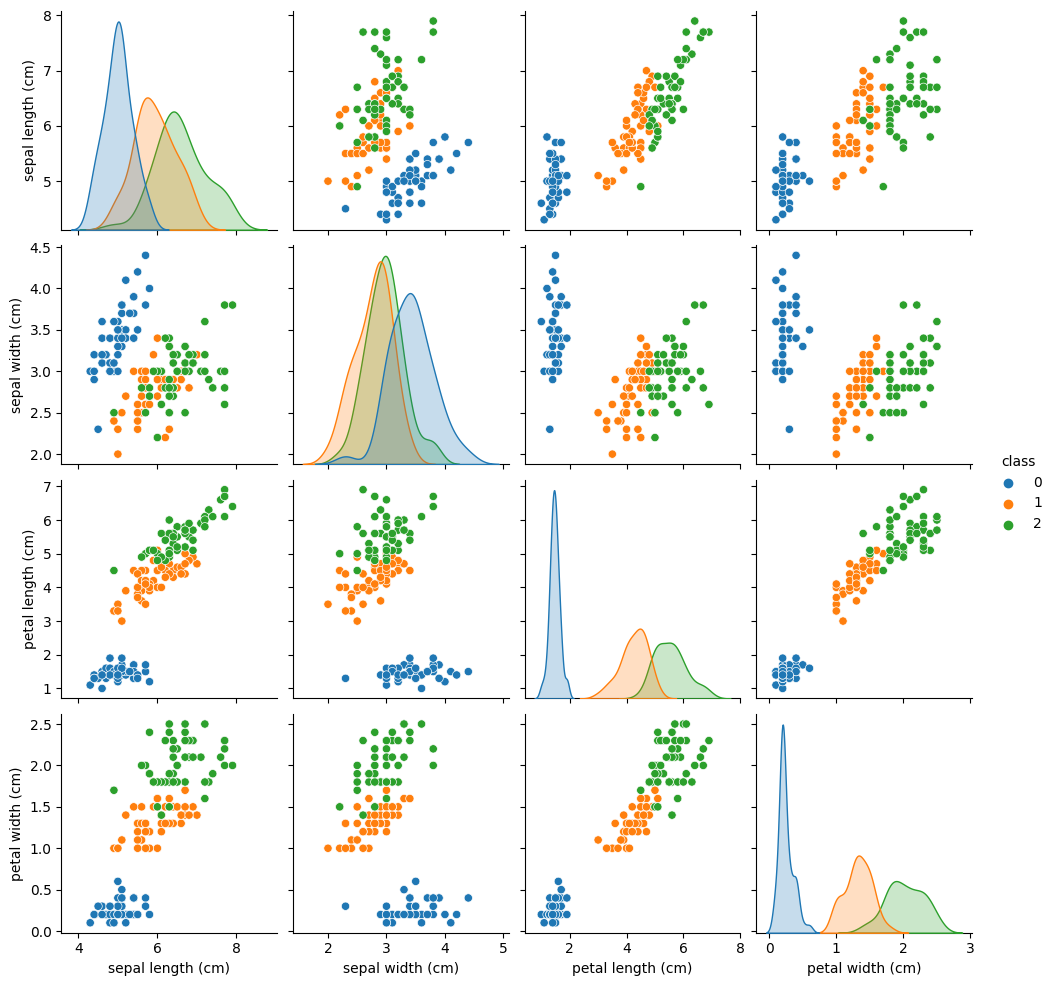

In [ ]:
import pandas as pd
import seaborn as sns

df = pd.DataFrame(iris_data.data, columns=iris_data.feature_names)
df["class"] = pd.Series(iris_data.target)

sns.pairplot(df, hue="class", palette="tab10")

In [ ]:
from sklearn.model_selection import train_test_split
from qiskit.utils import algorithm_globals

algorithm_globals.random_seed = 123
train_features, test_features, train_labels, test_labels = train_test_split(
    features, labels, train_size=0.8, random_state=algorithm_globals.random_seed
)

In [ ]:
train_labels

array([2, 2, 0, 0, 1, 1, 2, 0, 0, 1, 1, 0, 2, 2, 2, 2, 2, 1, 0, 0, 2, 0,
       0, 1, 1, 1, 1, 2, 1, 2, 0, 2, 1, 0, 0, 2, 1, 2, 2, 0, 1, 1, 2, 0,
       2, 1, 1, 0, 2, 2, 0, 0, 1, 1, 2, 0, 0, 1, 0, 1, 2, 0, 2, 0, 0, 1,
       0, 0, 1, 2, 1, 1, 1, 0, 0, 1, 2, 0, 0, 1, 1, 1, 2, 1, 1, 1, 2, 0,
       0, 1, 2, 2, 2, 2, 0, 1, 0, 1, 1, 0, 1, 2, 1, 2, 2, 0, 1, 0, 2, 2,
       1, 1, 2, 2, 1, 0, 1, 1, 2, 2])

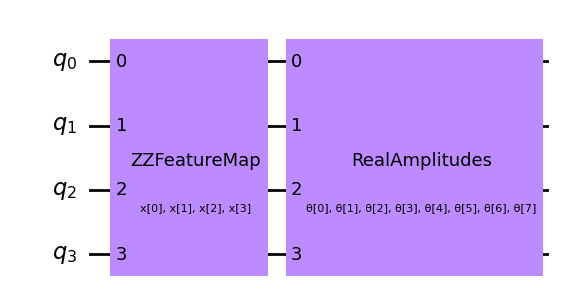

In [ ]:
from pylatexenc import *
num_inputs=4
# construct feature map
feature_map = ZZFeatureMap(num_inputs)

# construct ansatz
ansatz = RealAmplitudes(num_inputs, reps=1)

# construct quantum circuit
qc = QuantumCircuit(num_inputs)
qc.append(feature_map, range(num_inputs))
qc.append(ansatz, range(num_inputs))
qc.decompose().draw(output='mpl')


In [ ]:
# parity maps bitstrings to 0 or 1
def parity(x):
    return "{:b}".format(x).count("1") % 2


output_shape = 2  # corresponds to the number of classes, possible outcomes of the (parity) mapping.

In [ ]:
# construct QNN
sampler_qnn = SamplerQNN(
    circuit=qc,
    input_params=feature_map.parameters,
    weight_params=ansatz.parameters,
    interpret=parity,
    output_shape=output_shape,
)

NameError: ignored

In [ ]:
# callback function that draws a live plot when the .fit() method is called
def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

In [ ]:
# construct classifier
sampler_classifier = NeuralNetworkClassifier(
    neural_network=sampler_qnn, optimizer=COBYLA(maxiter=100), callback=callback_graph
)

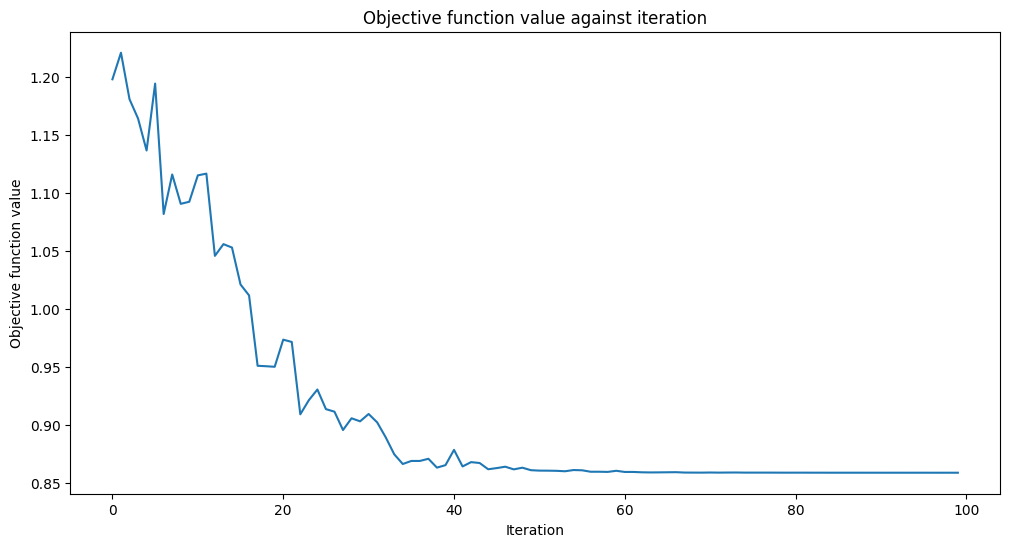

0.425

In [ ]:
# create empty array for callback to store evaluations of the objective function
objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)

# fit classifier to data
sampler_classifier.fit(train_features, train_labels)

# return to default figsize
plt.rcParams["figure.figsize"] = (6, 4)

# score classifier
sampler_classifier.score(train_features, train_labels)

In [ ]:
score=sampler_classifier.score(train_features, train_labels)
print(f"accuracy score: ",score)
# score classifier
print(f"Accuracy from the train data : {np.round(100 * sampler_classifier.score(train_features, train_labels), 2)}%")

accuracy score:  0.425
Accuracy from the train data : 42.5%


#end of code

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import clear_output
from qiskit import QuantumCircuit
from qiskit.algorithms.optimizers import COBYLA, L_BFGS_B
from qiskit.circuit import Parameter
from qiskit.circuit.library import RealAmplitudes, ZZFeatureMap
from qiskit.utils import algorithm_globals

from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier, VQC
from qiskit_machine_learning.algorithms.regressors import NeuralNetworkRegressor, VQR
from qiskit_machine_learning.neural_networks import SamplerQNN, EstimatorQNN

algorithm_globals.random_seed = 42

In [ ]:

data = pd.read_csv('/content/seeds.csv')

In [ ]:
print(data)

      Area  Perimeter  Compactness  Kernel.Length  Kernel.Width  \
0    15.26      14.84       0.8710          5.763         3.312   
1    14.88      14.57       0.8811          5.554         3.333   
2    14.29      14.09       0.9050          5.291         3.337   
3    13.84      13.94       0.8955          5.324         3.379   
4    16.14      14.99       0.9034          5.658         3.562   
..     ...        ...          ...            ...           ...   
194  12.19      13.20       0.8783          5.137         2.981   
195  11.23      12.88       0.8511          5.140         2.795   
196  13.20      13.66       0.8883          5.236         3.232   
197  11.84      13.21       0.8521          5.175         2.836   
198  12.30      13.34       0.8684          5.243         2.974   

     Asymmetry.Coeff  Kernel.Groove  Type  
0              2.221          5.220     1  
1              1.018          4.956     1  
2              2.699          4.825     1  
3              2.25

In [ ]:
features = data.drop('Type',axis = 1).values
labels = data['Type'].values

In [ ]:
from sklearn.preprocessing import MinMaxScaler

features = MinMaxScaler().fit_transform(features)

In [ ]:
from sklearn.model_selection import train_test_split
from qiskit.utils import algorithm_globals

algorithm_globals.random_seed = 123
train_features, test_features, train_labels, test_labels = train_test_split(
    features, labels, train_size=0.8, random_state=algorithm_globals.random_seed
)

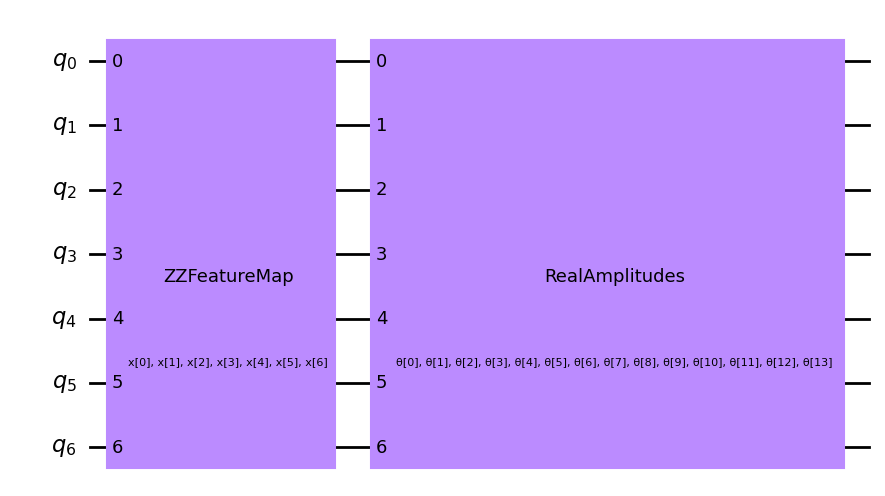

In [ ]:
from pylatexenc import *
num_inputs=7
# construct feature map
feature_map = ZZFeatureMap(num_inputs)

# construct ansatz
ansatz = RealAmplitudes(num_inputs, reps=1)

# construct quantum circuit
qc = QuantumCircuit(num_inputs)
qc.append(feature_map, range(num_inputs))
qc.append(ansatz, range(num_inputs))
qc.decompose().draw(output='mpl')



In [ ]:
# parity maps bitstrings to 0 or 1
def parity(x):
    return "{:b}".format(x).count("1") % 2

output_shape = 2  # corresponds to the number of classes, possible outcomes of the (parity) mapping.

In [ ]:
# construct QNN
sampler_qnn = SamplerQNN(
    circuit=qc,
    input_params=feature_map.parameters,
    weight_params=ansatz.parameters,
    interpret=parity,
    output_shape=output_shape,
)

In [ ]:
# callback function that draws a live plot when the .fit() method is called
def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

In [ ]:
# construct classifier
sampler_classifier = NeuralNetworkClassifier(
    neural_network=sampler_qnn, optimizer=COBYLA(maxiter=100), callback=callback_graph
)

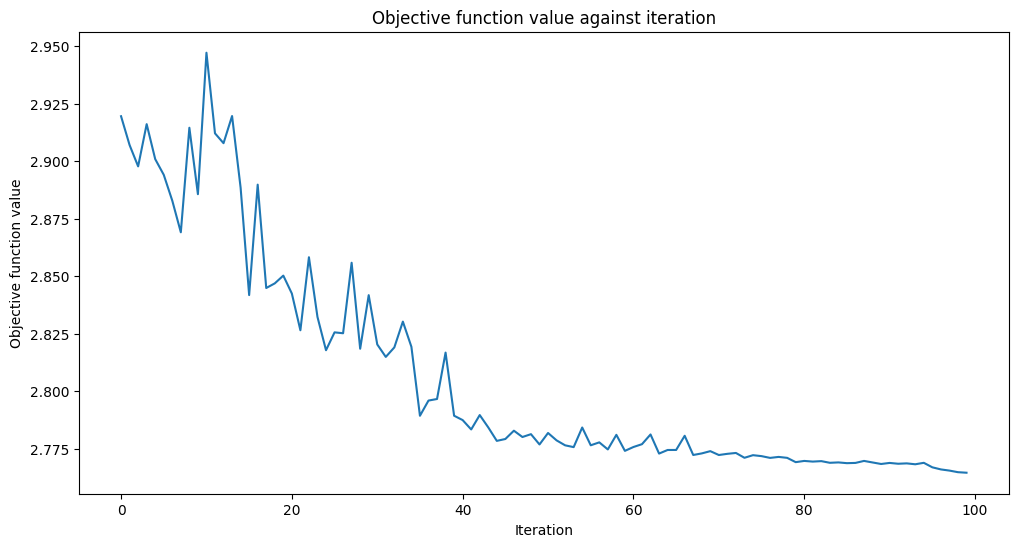

0.20754716981132076

In [ ]:
# create empty array for callback to store evaluations of the objective function
objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)

# fit classifier to data
sampler_classifier.fit(train_features, train_labels)

# return to default figsize
plt.rcParams["figure.figsize"] = (6, 4)

# score classifier
sampler_classifier.score(train_features, train_labels)

In [ ]:
score=sampler_classifier.score(train_features, train_labels)
print(f"accuracy score: ",score)
# score classifier
print(f"Accuracy from the train data : {np.round(100 * sampler_classifier.score(train_features, train_labels), 2)}%")

accuracy score:  0.20754716981132076
Accuracy from the train data : 20.75%
